In [9]:
import sys
import os
import json
from pathlib import Path
import tensorflow as tf
from keras import backend as K

from keras.optimizers.legacy import Adam, SGD

from utils.loss import *
from utils.metrics import *
from utils.dataset import *
from keras.layers import *
from keras.models import *

base_path = '/Users/lorenzofederici/Univpm/Tesi/LUS-multitask-learning'
if base_path not in sys.path:
    sys.path.append(base_path)

# import custom lib
from src.utils.dataset import *
from src.experiment import Experiment
from models import resnet18 as r

gpu = len(tf.config.list_physical_devices('GPU'))>0
if gpu:
    tf.config.set_visible_devices([tf.config.list_physical_devices('GPU')[0],tf.config.list_physical_devices('CPU')[0]])
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
    print("---> GPU is available <---")

exps_path = '/Users/lorenzofederici/Univpm/Tesi/LUS-multitask-learning/config/params.json'

with open(exps_path) as f:
    configs = json.load(f)

---> GPU is available <---


In [2]:
experiment = Experiment(base_path, output_mode= (True,True))
# TODO: chiedi a edo di smote

------------------------------------------------------------------------------------------
>> EXPERIMENT: exp_classification_ResNet_BS16_EP40_OPTAdam_LR0.0001_AUGTrue__DT1511_1326 <<
------------------------------------------------------------------------------------------
>>Setting:  {'IMG_SHAPE': 224, 'N_CLASS': 4, 'SEED': 42}
>>Experiment:  [{'backbone': 'ResNet', 'task': 'classification', 'out_class': 4, 'batch_size': 16, 'epoch': 40, 'split_ratio': [0.6, 0.2, 0.2], 'optimizer': 'Adam', 'lr': 0.0001, 'augmentation': True, 'weights': 'imagenet', 'layer_to_freeze': 'enc_2'}]

>> SPLITTING:
>>> Dataset Split: Train=1107(51%), Val=592(27%), Test=455(22%)
>>> Train Class Weights: {0: 0.7024111675126904, 1: 1.153125, 2: 0.8489263803680982, 3: 1.8826530612244898}
>>> Val Class Weights: {0: 0.7551020408163265, 1: 1.0422535211267605, 2: 0.783068783068783, 3: 2.276923076923077}
>>> Test Class Weights: {0: 1.0247747747747749, 1: 2.645348837209302, 2: 0.4478346456692913, 3: 2.4202127659574466}

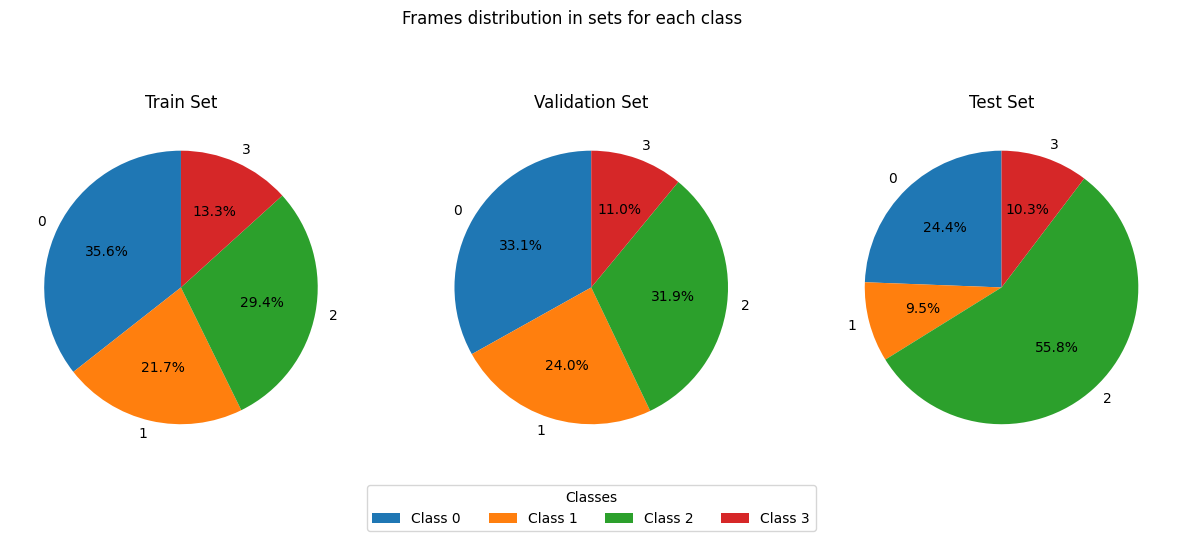

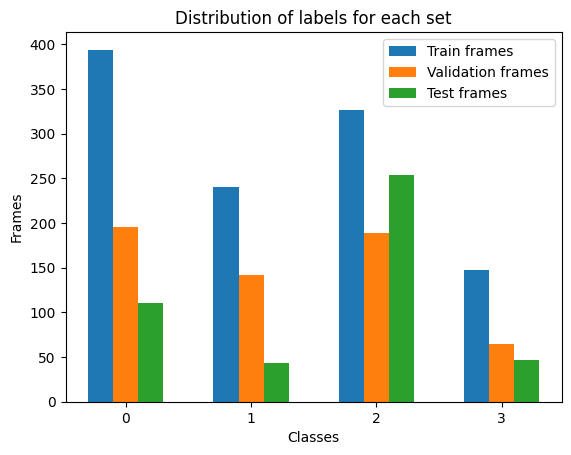

<Figure size 640x480 with 0 Axes>

In [10]:
idx = 1
configs_general = configs['SETTING']
configs_exps    = configs['EXPS'][idx]

for config in configs_exps:
    experiment.build_experiment(configs_general, config, seed = 17)

print('>>Setting: ', configs_general)
print('>>Experiment: ', configs_exps)

experiment.split_dataset()
experiment.generate_split_charts('ldistr')

In [11]:
K.clear_session
model = experiment.build_model()
model = experiment.compile_model(model)

>> Building model:
	Task --> classification
	Model --> ResUNet


In [12]:
# for i in model.layers:
#     print(i.name, i.trainable)

In [13]:
history = experiment.train_model(model)

------------------------------------------------------------
		   ~~~~~~ RUNNING ~~~~~~
------------------------------------------------------------
Epoch 1/40
70/70 [==============================] - 67s 865ms/step - loss: 1.2109 - accuracy: 0.5556 - val_loss: 1.4626 - val_accuracy: 0.3733
Epoch 2/40
70/70 [==============================] - 53s 761ms/step - loss: 0.8390 - accuracy: 0.6847 - val_loss: 2.0683 - val_accuracy: 0.3412
Epoch 3/40
70/70 [==============================] - 54s 781ms/step - loss: 0.6031 - accuracy: 0.7498 - val_loss: 1.3967 - val_accuracy: 0.3682
Epoch 4/40
70/70 [==============================] - 49s 711ms/step - loss: 0.5093 - accuracy: 0.8076 - val_loss: 2.0524 - val_accuracy: 0.3818
Epoch 5/40
70/70 [==============================] - 48s 693ms/step - loss: 0.4666 - accuracy: 0.8103 - val_loss: 2.0792 - val_accuracy: 0.3868
Epoch 6/40
70/70 [==============================] - 46s 662ms/step - loss: 0.4421 - accuracy: 0.8184 - val_loss: 1.7020 - val_accuracy: 

In [17]:
if not 'lr' in history.history:
    print('lollo')

lollo


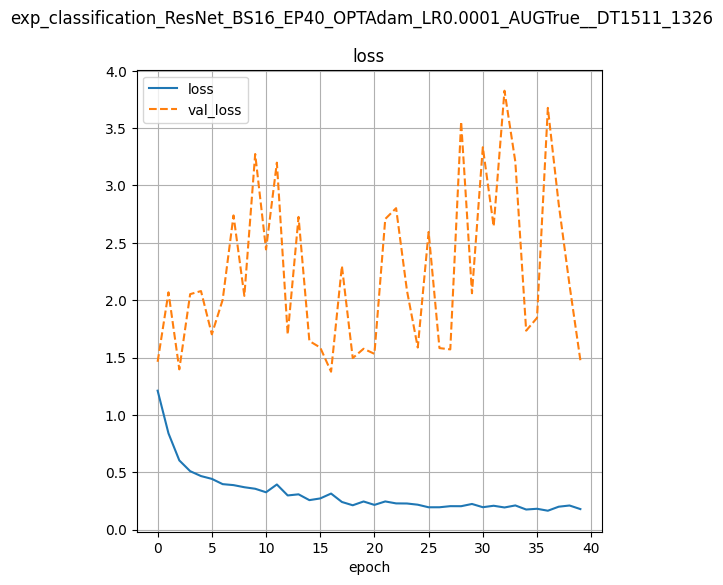

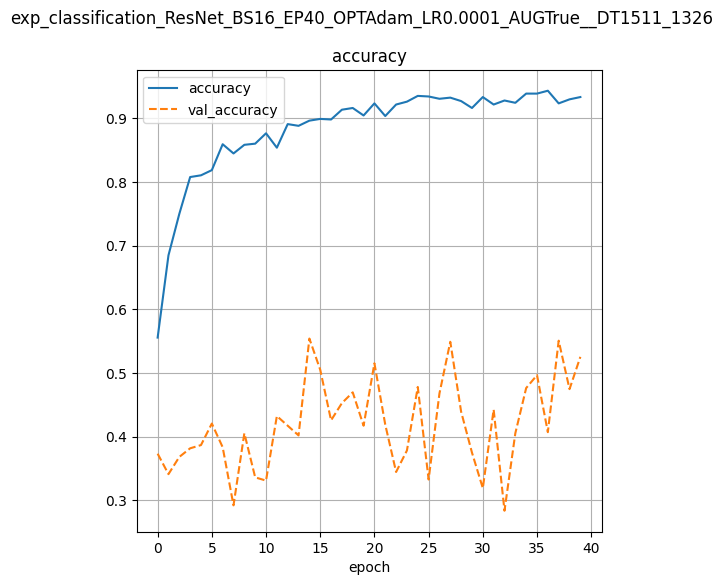

KeyError: 'lr'

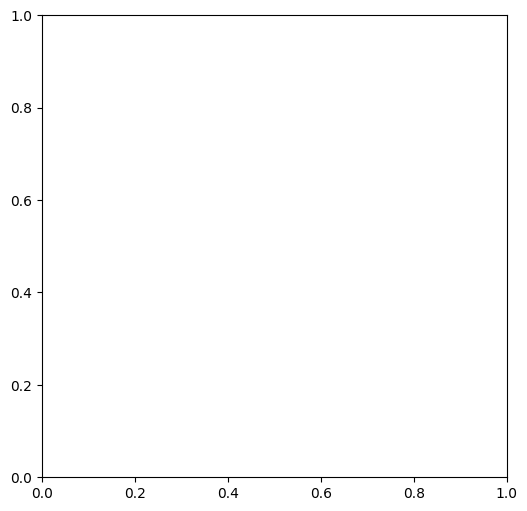

In [14]:
experiment.nn_train_graphs(history)

# Model

In [ ]:
K.clear_session()
model = r.resnet18(input_shape= (224,224,3), num_class=4)
# for layer in model.layers:
#     print(layer.name)

In [ ]:
def set_trainable_layers(model, stop_layer_name):
    stop_layer_found = False

    for layer in model.layers:
        layer.trainable = not stop_layer_found
        stop_layer_found = stop_layer_found or (layer.name == stop_layer_name)

# Esempio di utilizzo
set_trainable_layers(model, None)

In [ ]:
for layer in model.layers:
        print(layer.trainable)

In [ ]:
x = GlobalAveragePooling2D()(model.output)
x = Flatten()(x)
output = Dense(4, activation='softmax')(x)
model  = Model(inputs=[model.input], outputs=[output])

In [ ]:
model.compile(optimizer = Adam(learning_rate=0.0001),
                loss    = categorical_crossentropy,
                metrics = 'accuracy')

In [ ]:
# steps
batch_size = 16
train_samples = len(experiment.train_subset_idxs)
train_steps = train_samples // batch_size
if train_samples % batch_size != 0:
    train_steps += 1

val_samples = len(experiment.val_subset_idxs)
val_steps = val_samples // batch_size
if val_samples % batch_size != 0:
    val_steps += 1

history = model.fit(
    experiment.train_ds,
    epochs          = 20,
    steps_per_epoch=train_steps,
    validation_data = experiment.val_ds,
    class_weight    = experiment.class_weight_dicts[0],
    validation_steps=val_steps,
    workers = 7
)

In [ ]:
model.summary()

In [ ]:
experiment.nn_train_graphs(history)